In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np

math = pd.read_csv('stud_math.csv')
math.info()  # анализируем датафрейм, видим, что в колонках Аббревиатуры школы, Пола и Возраста нет пустых значений

pd.set_option('display.max_rows', 400)  # показывать больше строк
pd.set_option('display.max_columns', 30)  # показывать больше колонок

math.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [2]:
math = math.rename(columns={'famsize': 'family_size', 'Pstatus': 'marital_status', 'Medu': 'mother_edu', 'Fedu': 'father_edu',
                            'Mjob': 'mother_job', 'Fjob': 'father_job', 'schoolsup': 'school_sup', 'famsup': 'family_sup',
                            'famrel': 'family_rel', 'goout': 'go_out'})  # переименуем некоторые колонки

In [3]:
# определяем из скольких школ собраны данные, понимаем, что из 2 - 'GP' и 'MS'
display(math.school.unique())

# создадим датафрейм с колонками аббревиатуры школы, в которой учится ученик, типом адреса ученика ('U' - городской, 'R' - за городом) и
# временем в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.) для последующего анализа
dist = math[['school', 'address', 'traveltime']]

array(['GP', 'MS'], dtype=object)

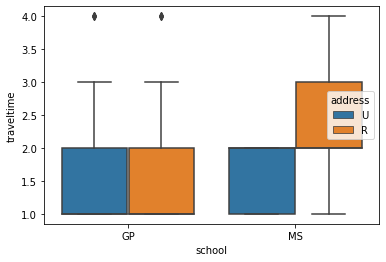

In [4]:
sns.boxplot(x='school', y='traveltime', data=dist,
            hue='address')  # построим график
# из графика видим, что до школы GP одинаковое время пути что из города, что из за города. Что же касается школы MS - до него добираться из за города дольше.

# убираем колонки school и address, как избыточные данные, не влияющие на успеваемость по математике
math.drop(['school', 'address'], inplace=True, axis=1)

,age,mother_edu,father_edu,traveltime,studytime,failures,"studytime, granular",family_rel,freetime,go_out,health,absences,score
age,1.000000,-0.161704,-0.138018,0.081508,-0.015556,0.228047,0.015556,0.068899,0.029023,0.135107,-0.065946,0.093592,-0.155726
mother_edu,-0.161704,1.000000,0.275598,-0.173515,0.078589,-0.245463,-0.078589,-0.010050,0.025335,0.064164,-0.045051,-0.011944,0.213349
father_edu,-0.138018,0.275598,1.000000,0.030646,0.057199,-0.150821,-0.057199,0.040577,-0.066556,-0.023282,0.027251,0.004695,0.078573
traveltime,0.081508,-0.173515,0.030646,1.000000,-0.102206,0.064699,0.102206,-0.016857,-0.021937,0.037636,-0.021531,-0.048215,-0.070559
studytime,-0.015556,0.078589,0.057199,-0.102206,1.000000,-0.178992,-1.000000,0.045894,-0.121969,-0.051280,-0.080016,-0.026544,0.115741
failures,0.228047,-0.245463,-0.150821,0.064699,-0.178992,1.000000,0.178992,-0.022655,0.098382,0.120914,0.081284,0.057391,-0.344338
"studytime, granular",0.015556,-0.078589,-0.057199,0.102206,-1.000000,0.178992,1.000000,-0.045894,0.121969,0.051280,0.080016,0.026544,-0.115741
family_rel,0.068899,-0.010050,0.040577,-0.016857,0.045894,-0.022655,-0.045894,1.000000,0.175743,0.081154,0.077474,-0.082609,0.057112
freetime,0.029023,0.025335,-0.066556,-0.021937,-0.121969,0.098382,0.121969,0.175743,1.000000,0.296437,0.061575,0.009292,0.019026
go_out,0.135107,0.064164,-0.023282,0.037636,-0.051280,0.120914,0.051280,0.081154,0.296437,1.000000,-0.015608,-0.048738,-0.129685


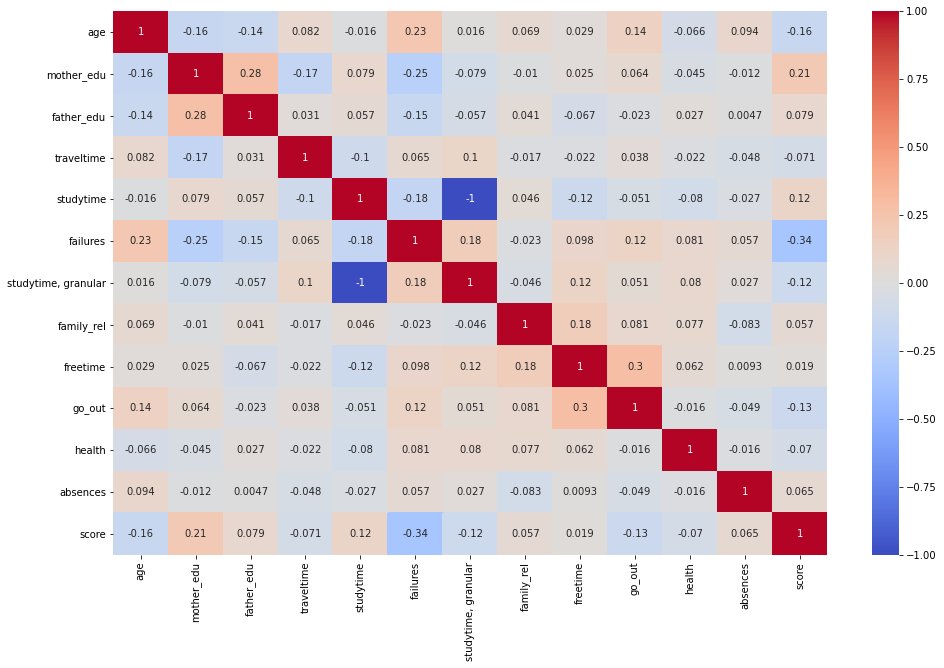

In [6]:
# смотрим матрицу корреляций:
display(math.corr())
# глаза разбегаются. Используем тепловую карту, чтобы визуально определить степени корреляции:
corr_math = math.corr()
# указываем размер фигуры в дюймах, чтобы все значения влезли в квадратики
plt.figure(figsize=(16, 10))
# начертим тепловую карту
sns.heatmap(corr_math, annot=True, cmap='coolwarm')
# видим, что столбец studytime полностью коррелируется со столбцом studytime, granular
# убираем избыточный столбец studytime, granular
math.drop(['studytime, granular'], inplace=True, axis=1)

<AxesSubplot:xlabel='variable', ylabel='value'>

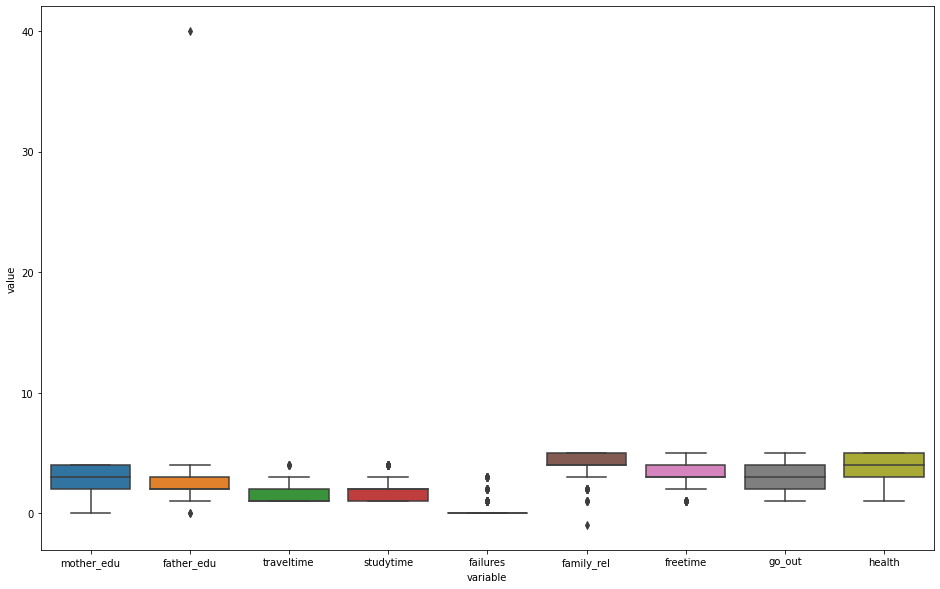

In [8]:
plt.figure(figsize=(16, 10))
df = pd.DataFrame(data=math, columns=['mother_edu', 'father_edu', 'traveltime', 'studytime', 'failures', 'family_rel', 'freetime', 'go_out', 'health'])
display(sns.boxplot(x="variable", y="value", data=pd.melt(df)))


In [4]:
print('Выбивающиеся значения - ячейка, число: ',
      math.father_edu[math.father_edu > 4])  # ищем выбивающиеся значения
# предполагаем, что 40 - это была 4, просто 0 появился
math.loc[11, 'father_edu'] = 4  # исправляем ячейку

Выбивающиеся значения - ячейка, число:  11    40.0
Name: father_edu, dtype: float64


<AxesSubplot:xlabel='variable', ylabel='value'>

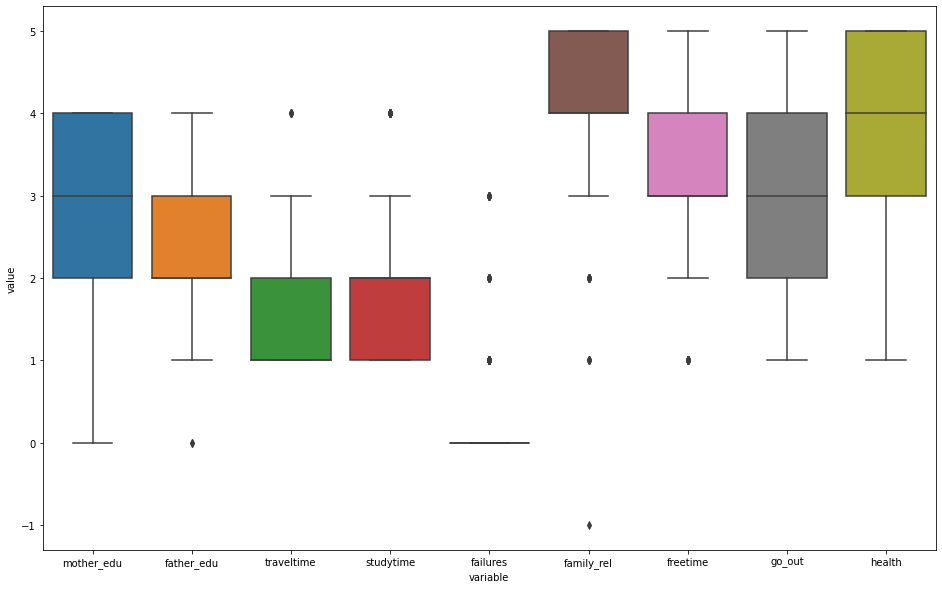

In [5]:
plt.figure(figsize=(16, 10))
df = pd.DataFrame(data=math, columns=['mother_edu', 'father_edu', 'traveltime', 'studytime', 'failures', 'family_rel', 'freetime', 'go_out', 'health'])
display(sns.boxplot(x="variable", y="value", data=pd.melt(df)))

<AxesSubplot:xlabel='value', ylabel='variable'>

school                       GP
sex                           F
age                          16
address                       U
family_size                 GT3
marital_status                T
mother_edu                    2
father_edu                    3
mother_job             services
father_job              teacher
reason                    other
guardian                 mother
traveltime                    1
studytime                     2
failures                      0
school_sup                  yes
family_sup                  NaN
paid                         no
activities                   no
nursery                     yes
studytime, granular          -6
higher                      yes
internet                    yes
romantic                     no
family_rel                    2
freetime                      3
go_out                        1
health                        3
absences                    385
score                        85
Name: 222, dtype: object

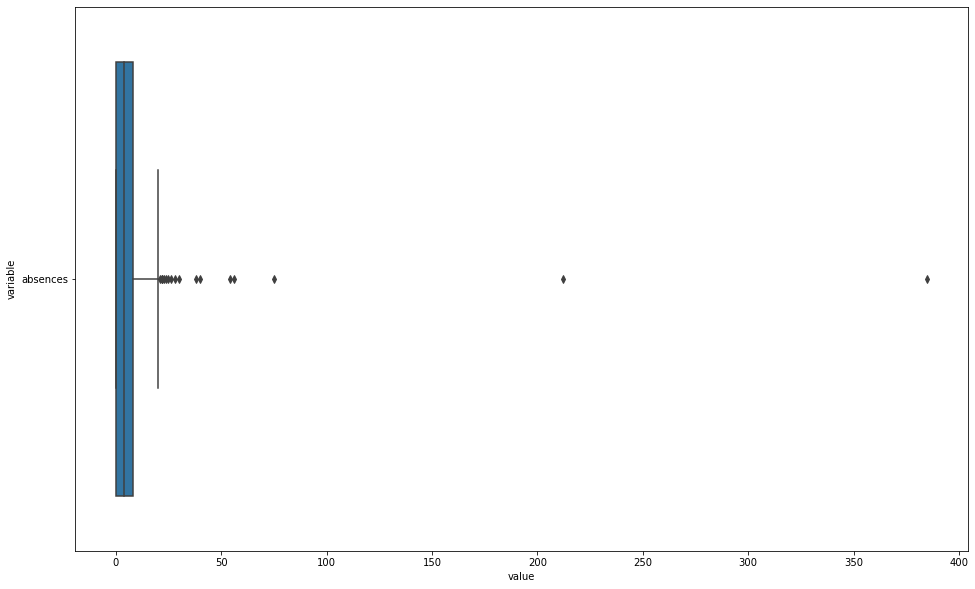

In [5]:
plt.figure(figsize=(16, 10))
dff = pd.DataFrame(data=math, columns=['absences'])
display(sns.boxplot(x="value", y="variable", data=pd.melt(dff)))
# absences — количество пропущенных занятий
math[math.absences>20]
math.loc[222]

25-й перцентиль: 0.0, 75-й перцентиль: 6.0, IQR: 6.0,  Границы выбросов: [-9.0, 15.0].


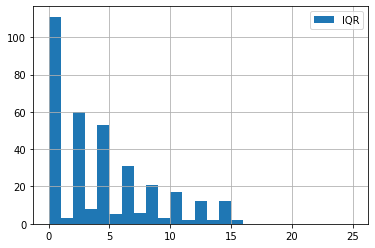

In [23]:


math[math.absences>50]
math.absences.median()

IQR = math.absences.quantile(0.75) - math.absences.quantile(0.25)
perc25 = math.absences.quantile(0.25)
perc75 = math.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

math.absences.loc[math.absences.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=25, range=(0, 25), label='IQR')

plt.legend()


In [18]:
math = math.loc[math.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] # отфильтруем данные
math.absences # он удаляет данне что вылезает за эти значения - не очень вариант

0       6.0
1       4.0
2      10.0
3       2.0
4       4.0
5      10.0
6       0.0
7       6.0
8       0.0
9       0.0
10      0.0
11      4.0
12      2.0
13      2.0
14      0.0
15      4.0
16      6.0
17      4.0
18     16.0
19      4.0
20      0.0
21      0.0
22      2.0
23      0.0
25     14.0
26      2.0
27      4.0
28      4.0
29     16.0
30      0.0
31      0.0
32      0.0
33      0.0
34      0.0
35      0.0
36      2.0
37      7.0
38      2.0
39      8.0
41      8.0
42      2.0
43      0.0
44     14.0
45      8.0
46     12.0
47      4.0
48      2.0
49      2.0
50      2.0
51      2.0
52      6.0
53      0.0
54      6.0
55      8.0
56      0.0
57      4.0
58      2.0
59      2.0
60      6.0
61      6.0
62      4.0
63      2.0
64      0.0
65      2.0
66      4.0
67      4.0
68      2.0
69     12.0
70      0.0
71      0.0
72      2.0
73      2.0
75      6.0
76      8.0
77      0.0
78      2.0
79     12.0
80      2.0
81      4.0
82     10.0
83      4.0
84      2.0
85      6.0
86  

In [19]:
math.reset_index()
math[math.score==85]
math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               356 non-null    object 
 1   sex                  356 non-null    object 
 2   age                  356 non-null    int64  
 3   address              341 non-null    object 
 4   family_size          335 non-null    object 
 5   marital_status       319 non-null    object 
 6   mother_edu           353 non-null    float64
 7   father_edu           334 non-null    float64
 8   mother_job           340 non-null    object 
 9   father_job           324 non-null    object 
 10  reason               339 non-null    object 
 11  guardian             326 non-null    object 
 12  traveltime           329 non-null    float64
 13  studytime            351 non-null    float64
 14  failures             337 non-null    float64
 15  school_sup           347 non-null    obj

<AxesSubplot:xlabel='value', ylabel='variable'>

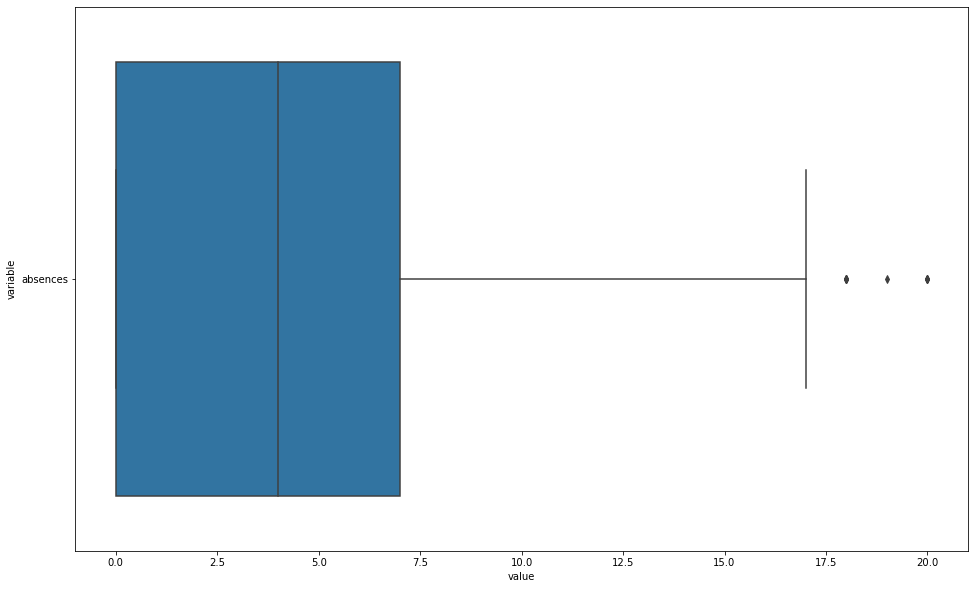

In [33]:
plt.figure(figsize=(16, 10))
dff = pd.DataFrame(data=math, columns=['absences'])
display(sns.boxplot(x="value", y="variable", data=pd.melt(dff)))
# absences — количество пропущенных занятий


     variable  value
0    absences    6.0
1    absences    4.0
2    absences   10.0
3    absences    2.0
4    absences    4.0
5    absences   10.0
6    absences    0.0
7    absences    6.0
8    absences    0.0
9    absences    0.0
10   absences    0.0
11   absences    4.0
12   absences    2.0
13   absences    2.0
14   absences    0.0
15   absences    4.0
16   absences    6.0
17   absences    4.0
18   absences   16.0
19   absences    4.0
20   absences    0.0
21   absences    0.0
22   absences    2.0
23   absences    0.0
24   absences    NaN
25   absences   14.0
26   absences    2.0
27   absences    4.0
28   absences    4.0
29   absences   16.0
30   absences    0.0
31   absences    0.0
32   absences    0.0
33   absences    0.0
34   absences    0.0
35   absences    0.0
36   absences    2.0
37   absences    7.0
38   absences    2.0
39   absences    8.0
40   absences   25.0
41   absences    8.0
42   absences    2.0
43   absences    0.0
44   absences   14.0
45   absences    8.0
46   absences

Text(0.5, 1.0, 'Changed Outlier Symbols')

<Figure size 1152x720 with 0 Axes>

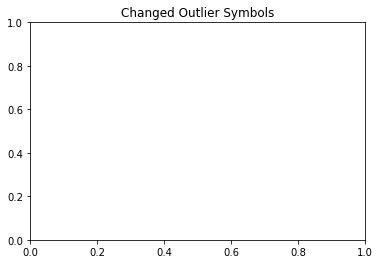

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Make some dummy data
plt.figure(figsize=(16, 10))
dff = pd.DataFrame(data=math, columns=['absences'])
dummy_data = pd.melt(dff)

print(dummy_data)
def make_labels(ax, boxplot):

    # Grab the relevant Line2D instances from the boxplot dictionary
    iqr = boxplot['boxes'][0]
    caps = boxplot['caps']
    med = boxplot['medians'][0]
    fly = boxplot['fliers'][0]

    # The x position of the median line
    xpos = med.get_xdata()

    # Lets make the text have a horizontal offset which is some 
    # fraction of the width of the box
    xoff = 0.10 * (xpos[1] - xpos[0])

    # The x position of the labels
    xlabel = xpos[1] + xoff

    # The median is the y-position of the median line
    median = med.get_ydata()[1]

    # The 25th and 75th percentiles are found from the
    # top and bottom (max and min) of the box
    pc25 = iqr.get_ydata().min()
    pc75 = iqr.get_ydata().max()

    # The caps give the vertical position of the ends of the whiskers
    capbottom = caps[0].get_ydata()[0]
    captop = caps[1].get_ydata()[0]

    # Make some labels on the figure using the values derived above
    ax.text(xlabel, median,
            'Median = {:6.3g}'.format(median), va='center')
    ax.text(xlabel, pc25,
            '25th percentile = {:6.3g}'.format(pc25), va='center')
    ax.text(xlabel, pc75,
            '75th percentile = {:6.3g}'.format(pc75), va='center')
    ax.text(xlabel, capbottom,
            'Bottom cap = {:6.3g}'.format(capbottom), va='center')
    ax.text(xlabel, captop,
            'Top cap = {:6.3g}'.format(captop), va='center')

    # Many fliers, so we loop over them and create a label for each one
    for flier in fly.get_ydata():
        ax.text(1 + xoff, flier,
                'Flier = {:6.3g}'.format(flier), va='center')

# Make the figure
red_diamond = dict(markerfacecolor='r', marker='D')
fig3, ax3 = plt.subplots()
ax3.set_title('Changed Outlier Symbols')

# Create the boxplot and store the resulting python dictionary
#my_boxes = ax3.boxplot(dummy_data, flierprops=red_diamond)

# Call the function to make labels
#make_labels(ax3, my_boxes)

#plt.show()


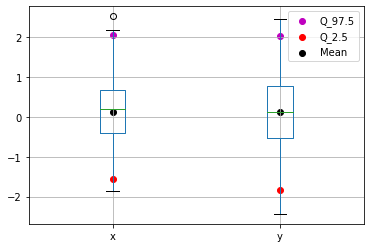

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

shape = (100,2)

df = pd.DataFrame(np.random.randn(*shape), columns=['x', 'y'])
df.boxplot(return_type='axes')

q975 = df.quantile(0.975)
q025 = df.quantile(0.025)
mean = df.mean()

plt.scatter(range(1,shape[1]+1), q975, c='m', label='Q_97.5')
plt.scatter(range(1,shape[1]+1), q025, c='r', label='Q_2.5')
plt.scatter(range(1,shape[1]+1), mean, c='k', label='Mean')

plt.legend()

plt.show()

In [6]:
# создадим функцию
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(10, 2))
    sns.boxplot(x=column, data=math, ax=ax)
    plt.xticks()
    ax.set_title('Boxplot for ' + column)
    plt.show()

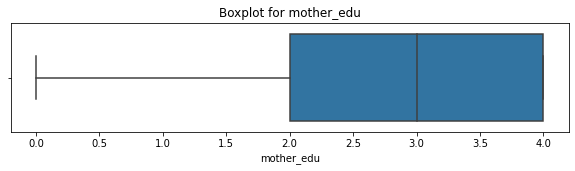

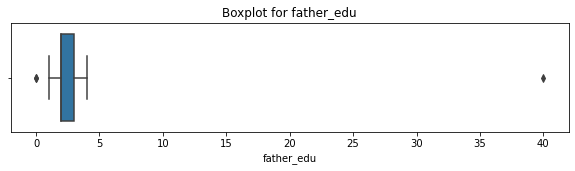

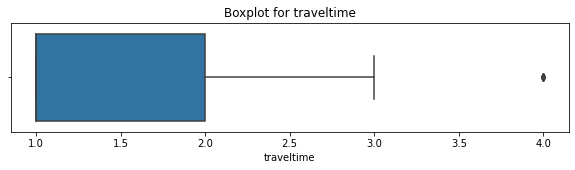

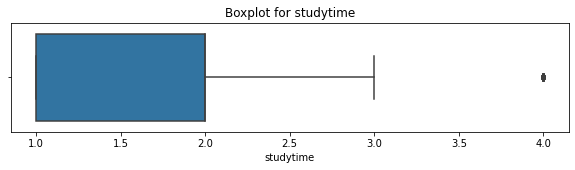

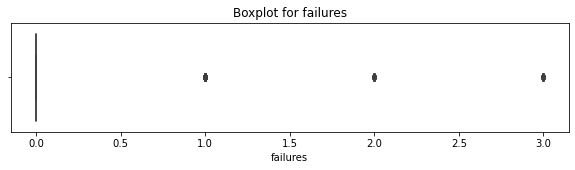

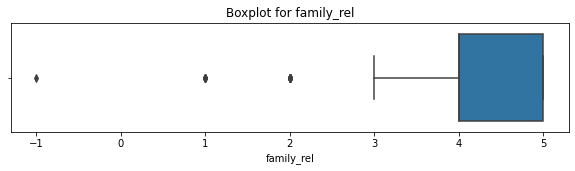

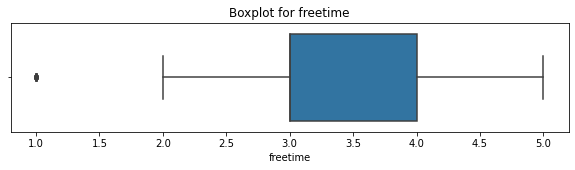

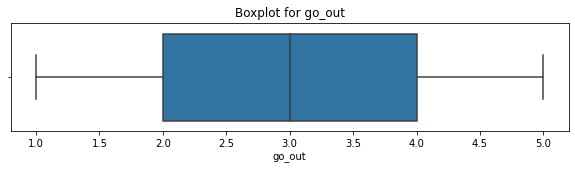

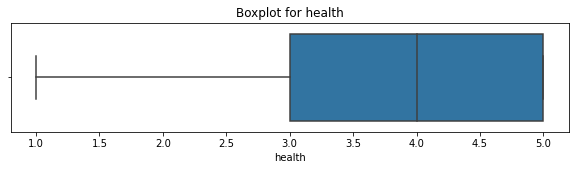

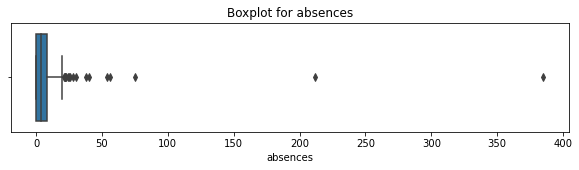

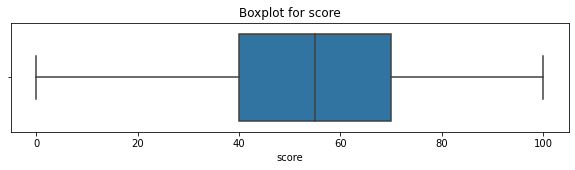

In [7]:
for column in ['mother_edu', 'father_edu', 'traveltime', 'studytime', 'failures', 'family_rel', 'freetime', 'go_out', 'health', 'absences', 'score']:
    get_boxplot(column)

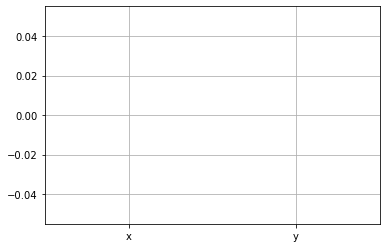

In [26]:
shape = (100,2)

df = pd.DataFrame(data=math, columns=['x', 'y'])
df.boxplot(return_type='axes')

q975 = df.quantile(0.975)
q025 = df.quantile(0.025)
mean = df.mean()

plt.scatter(range(1,shape[1]+1), q975, c='m', label='Q_97.5')
plt.scatter(range(1,shape[1]+1), q025, c='r', label='Q_2.5')
plt.scatter(range(1,shape[1]+1), mean, c='k', label='Mean')

In [24]:
'''IQR = cacao.rating.quantile(0.75) - cacao.rating.quantile(0.25)
perc25 = cacao.rating.quantile(0.25)
perc75 = cacao.rating.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

cacao.rating.loc[cacao.rating.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=10, range=(0, 10), label='IQR')

plt.legend()'''

# тут если много выбросов будет надо сделать

'IQR = cacao.rating.quantile(0.75) - cacao.rating.quantile(0.25)\nperc25 = cacao.rating.quantile(0.25)\nperc75 = cacao.rating.quantile(0.75)\nprint(\'25-й перцентиль: {},\'.format(perc25), \'75-й перцентиль: {},\'.format(perc75),\n      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))\n\ncacao.rating.loc[cacao.rating.between(\n    perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=10, range=(0, 10), label=\'IQR\')\n\nplt.legend()'

In [ ]:
"""заполнение пропущенных значений!!!!! пример"""
# Способ 1: Средние арифметические
df['Age'].fillna(round(df['Age'].mean(), 2))
# Способ 2: Cредние арифметические в зависимости от класса каюты
age_1 = df[df['Pclass'] == 1]['Age'].mean()
age_2 = df[df['Pclass'] == 2]['Age'].mean()
age_3 = df[df['Pclass'] == 3]['Age'].mean()
def fill_age(row):
    if pd.isnull(row['Age']):
        if row['Pclass'] == 1:
            return age_1
        if row['Pclass'] == 2:
            return age_2
        return age_3
    return row['Age']
df['Age'] = df.apply(fill_age, axis = 1)

In [50]:
'''на будущее 
# Найдем близко коррелирующие между собой столбцы:

corr_math = math.corr()

# извлечем верхний треугольник матрицы корреляции (он симметричный), исключая диагональ,
# используя np.tril (преобразует указанный массив в треугольный у которого все элементы выше указанной диагонали равны 0)
# и получаем противоположное ему с помощью оператора ~ .
corr = corr_math.where(~np.tril(np.ones(corr_math.shape)).astype(np.bool))
# разворачиваем данные и превращаем колонки в строки  -->  получаем Series
corr = corr.stack()
# ищем столбцы коррелирующие между собой на значениях меньше -0.8 или больше 0.8
print("Близко коррелирующие между собой столбцы: ",
      corr[(corr < -0.8) | (corr > 0.8)])

'''

'на будущее \n# извлечем верхний треугольник матрицы корреляции (он симметричный), исключая диагональ,\n# используя np.tril (преобразует указанный массив в треугольный у которого все элементы выше указанной диагонали равны 0)\n# и получаем противоположное ему с помощью оператора ~ .\ncorr = corr_math.where(~np.tril(np.ones(corr_math.shape)).astype(np.bool))\n# разворачиваем данные и превращаем колонки в строки  -->  получаем Series\ncorr = corr.stack()\n# ищем столбцы коррелирующие между собой на значениях меньше -0.8 или больше 0.8\nprint("Близко коррелирующие между собой столбцы: ",\n      corr[(corr < -0.8) | (corr > 0.8)])\n\n'